In [2]:
%pylab inline
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import os
import cv2
import random

Populating the interactive namespace from numpy and matplotlib


In [3]:
import torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [23]:
tY = torch.tensor([0])

In [24]:
testloss = torch.nn.CrossEntropyLoss()
wtf = torch.tensor([[9.0, 0.0, 0.0]])
testloss(wtf, tY)

tensor(0.0002)

In [3]:
base_path = '100_leaves_plant_species/data'
cats = os.listdir(base_path)
data = {}
for cat in cats:
    images = os.listdir(os.path.join(base_path, cat))
    data[cat] = [cv2.resize(cv2.imread(os.path.join(base_path, cat, image), cv2.IMREAD_GRAYSCALE), dsize=(60, 60),
                            interpolation=cv2.INTER_CUBIC) for image in images]

In [4]:
data

{'Quercus_Semecarpifolia': [array([[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
  array([[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
  array([[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
  array([[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
  array([[0, 0, 0, ..., 0, 0, 0],
        

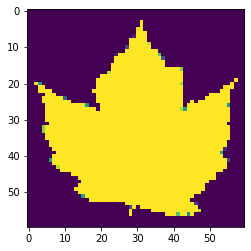

In [5]:
imshow(data[
    'Acer_Rubrum'
][8])

In [6]:
data[
    'Acer_Rubrum'
][8].shape

(60, 60)

In [7]:
len(data.keys())

100

In [8]:
i = 0
lens = []
for (_, arr) in data.items():
    lens.append(len(arr))
    for val in arr:
        i += 1
i

1600

In [9]:
class LeafNet(nn.Module):

    def __init__(self):
        super(LeafNet, self).__init__()

        self.convs = nn.Sequential(
            nn.Conv2d(1, 64, 5),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 96, 3),
            nn.BatchNorm2d(96),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
        )

        self.lins = nn.Sequential(
            nn.Linear(16224, 8112),
            nn.ReLU(inplace=True),
            nn.Linear(8112, 4056),
            nn.ReLU(inplace=True),
        )
        
        self.classifier = nn.Linear(4056, 100)
        self.dropout = nn.Dropout(0.15)

    def forward(self, x):
        x = self.convs(x)
        x = self.dropout(x)

        # print('shape', x.shape)
        x = x.reshape(x.size(0), -1)
        x = self.lins(x)

        x = self.classifier(x)

        return x


model = LeafNet()
model.to('cuda:0')

LeafNet(
  (convs): Sequential(
    (0): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1))
    (5): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (lins): Sequential(
    (0): Linear(in_features=16224, out_features=8112, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=8112, out_features=4056, bias=True)
    (3): ReLU(inplace=True)
  )
  (classifier): Linear(in_features=4056, out_features=100, bias=True)
  (dropout): Dropout(p=0.15, inplace=False)
)

In [10]:
optimizer = optim.Adam(model.parameters(), lr=3e-4, betas=(0.9, 0.999), eps=1e-7, amsgrad=False) # 3e-4 0.0003

EPOCHS = 5
BATCH = 4

loss_fn = nn.CrossEntropyLoss()

In [11]:
# TODO: clean up
def _flatten(d):
    images = []
    labels = []
    for (label, arr) in d.items():
        for image in arr:
            images.append(image)
            labels.append(label)
    return images, labels

In [12]:
def to_categorical(labels):
    categories = {}
    id = 0
    for item in labels:
        if item not in categories.keys():
            categories[item] = id
            id += 1
    res = []
    for item in labels:
        res.append(categories[item])
    return res

In [13]:
l = list(data.items())
data_s = dict(l)
images, labels_str = _flatten(data_s)
labels = to_categorical(labels_str)

random.seed(4)
random.shuffle(images)
random.shuffle(labels)

In [14]:
def to_batches(arr, n=1):
    return [arr[i * n:(i + 1) * n] for i in range((len(arr) + n - 1) // n )] 

In [15]:
images_train = images[:1200]
labels_train = labels[:1200]
images_test = images[-400:]
labels_test = labels[-400:]

In [16]:
images_b = to_batches(images_train, BATCH)
labels_b = to_batches(labels_train, BATCH)

In [17]:
def to_onehot(x, n=100):
    e = np.eye(n)
    return e[x]

In [18]:
losses = []
accuracies = []
model.train();
for i in tqdm(range(EPOCHS)):
    for (images, labels) in zip(images_b, labels_b):
    
        optimizer.zero_grad()
    
        X = torch.tensor(images).float().to('cuda:0').reshape(BATCH, 1, 60, 60) / 255
        
        oh = list(map(lambda x : to_onehot(x), labels))
        # print('onehot', oh)
        
        Y = torch.tensor(oh).long().to('cuda:0')
        
        out = model(X)
        # print('out', out)
        
        cat = torch.argmax(Y, dim=1)

        out_max = torch.argmax(out, dim=1)

        accuracy = (cat == out_max).float().mean()
        
        # print('Y', Y)
        # print('cat', cat)
        # print('out_max', out_max)

        loss = loss_fn(out, cat)
        # print('loss', loss)
        
        loss.backward()

        optimizer.step()

        losses.append(loss.item())
        accuracies.append(accuracy.item())


  0%|                                                                                                              | 0/5 [00:00<?, ?it/s]/usr/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /build/python-pytorch/src/pytorch-1.9.0-cuda/c10/core/TensorImpl.h:1153.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:15<00:00, 15.05s/it]


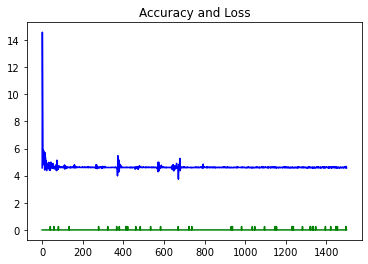

In [19]:
plt.plot(range(1500), accuracies, 'g', label='Accuracy')
plt.plot(range(1500), losses, 'b', label='Loss')
plt.title('Accuracy and Loss')
plt.show()

In [20]:
total = 0
correct = 0
model.eval();
with torch.no_grad():
    test_data = range(len(images_test))
    for i in tqdm(test_data):
        X_test = images_test[i]
        Y_test = labels_test[i]
        
        Y_temp = torch.tensor([to_onehot(Y_test)]).to('cuda:0').long()
        # print(Y_temp)
        Y = torch.argmax(Y_temp)
        # print(Y)

        X = torch.tensor(X_test).to('cuda:0').float() / 255

        X = X.reshape(1, 1, 60, 60)

        out = model(X)
        
        # print(out)
        prediction = torch.argmax(out)
        # print(prediction)

        # real = torch.argmax(torch.tensor(Y_test).to('cuda:0'))
        if prediction == Y:
            correct += 1

        total += 1

print('total', total)
print('correct', correct)
print('accuracy', round(correct / total, 3))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [00:00<00:00, 482.44it/s]

total 400
correct 0
accuracy 0.0
